In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
from tensorflow.data.experimental import sample_from_datasets

tfkl = tfk.layers

**Preprocessing**

As typical, we'll start with the MNIST data. Recall from last time, we have to do some transformations and preprocessing on these images.

In [2]:
data, info = tfds.load('mnist', with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))

ds_train = data["train"].map(preprocess).cache().batch(32)
ds_test = data["test"].map(preprocess).cache().batch(32)

In [4]:
img_shape = info.features['image'].shape

In [5]:
img_shape

(28, 28, 1)

**CNNs in TF Keras**

We'll use the Sequential class rely on new layer types that correspond to concepts we covered in lecture: Conv2D, AvgPool2D, MaxPool2D. 

Details such as kernel size, padding, strides and so on must be specified as args to these classes, where appropriate.

In [6]:
model = tfk.Sequential()
model.add(tfkl.Conv2D(filters = 1, kernel_size=(3,3), strides=(1,1), 
                      padding="valid", activation='relu', input_shape=(28, 28, 1)))
model.add(tfkl.MaxPool2D(pool_size=(4,4)))
model.add(tfkl.Flatten())
model.add(tfkl.Dense(10, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 1)         10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 1)           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                370       
Total params: 380
Trainable params: 380
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

results = model.fit(ds_train, steps_per_epoch=20, epochs=20, validation_data=ds_test)

Epoch 1/20
20/20 [==============================] - 3s 133ms/step - loss: 2.3120 - val_loss: 2.2930
Epoch 2/20
20/20 [==============================] - 1s 69ms/step - loss: 2.2800 - val_loss: 2.2728
Epoch 3/20
20/20 [==============================] - 1s 69ms/step - loss: 2.2581 - val_loss: 2.2521
Epoch 4/20
20/20 [==============================] - 1s 69ms/step - loss: 2.2379 - val_loss: 2.2290
Epoch 5/20
20/20 [==============================] - 1s 70ms/step - loss: 2.2192 - val_loss: 2.2048
Epoch 6/20
20/20 [==============================] - 1s 68ms/step - loss: 2.1689 - val_loss: 2.1758
Epoch 7/20
20/20 [==============================] - 1s 68ms/step - loss: 2.1604 - val_loss: 2.1461
Epoch 8/20
20/20 [==============================] - 1s 69ms/step - loss: 2.1299 - val_loss: 2.1139
Epoch 9/20
20/20 [==============================] - 1s 70ms/step - loss: 2.0796 - val_loss: 2.0759
Epoch 10/20
20/20 [==============================] - 1s 71ms/step - loss: 2.0581 - val_loss: 2.0364
Epoch 11

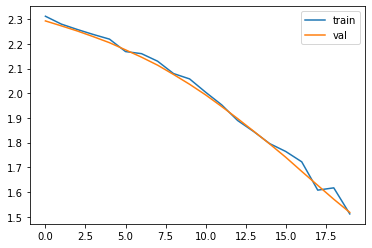

In [9]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Probability')

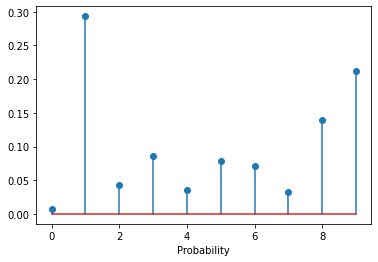

In [10]:
plt.stem(model.predict(ds_test.take(1))[9, :])
plt.xlabel("Digit")
plt.xlabel("Probability")

Which architectural hyperparameters might we change in the above?



**Exercise - Deep CNN**

Build and fit your own CNN model with 3 convolutional **modules**, where each one contains:
  * kernel convolution 
    * you pick number of kernels
    * you pick kernel shape/size
    * you pick activation
  * pooling
  * dropout

We'll use the Fashion MNIST dataset, a low-res collection of images of clothing.

In [11]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
images = images[:, :, :, np.newaxis]
labels = tf.one_hot(labels.astype(np.int32),depth=10)

# optional - TF Datasets objects
#fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
#fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

4423680/4422102 [==============================] - 0s 0us/step


In [12]:
labels

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

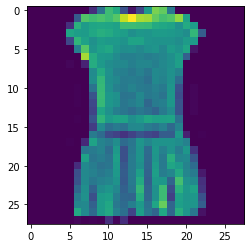

In [13]:
plt.imshow(images[3, :, :, :].squeeze())

In [14]:
model = tfk.Sequential()

# block 1
model.add(tfkl.Conv2D(filters = 32, kernel_size=2, strides=2, 
                      padding="valid", activation='relu', input_shape=(28, 28, 1)))
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

# block 2
model.add(tfkl.Conv2D(filters = 16, kernel_size=2, strides=1, 
                      padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

# block 3
model.add(tfkl.Conv2D(filters = 8, kernel_size=2, strides=1, 
                      padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=2))
model.add(tfkl.Dropout(.2))

model.add(tfkl.Flatten())
model.add(tfkl.Dense(10, activation='softmax'))

In [15]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

results = model.fit(ds_train, steps_per_epoch=20, epochs=20, validation_data=ds_test)

Epoch 1/20
20/20 [==============================] - 1s 49ms/step - loss: 2.3033 - val_loss: 2.3003
Epoch 2/20
20/20 [==============================] - 1s 44ms/step - loss: 2.3046 - val_loss: 2.2957
Epoch 3/20
20/20 [==============================] - 1s 44ms/step - loss: 2.2949 - val_loss: 2.2895
Epoch 4/20
20/20 [==============================] - 1s 44ms/step - loss: 2.2896 - val_loss: 2.2814
Epoch 5/20
20/20 [==============================] - 1s 44ms/step - loss: 2.2843 - val_loss: 2.2747
Epoch 6/20
20/20 [==============================] - 1s 44ms/step - loss: 2.2793 - val_loss: 2.2642
Epoch 7/20
20/20 [==============================] - 1s 45ms/step - loss: 2.2620 - val_loss: 2.2505
Epoch 8/20
20/20 [==============================] - 1s 44ms/step - loss: 2.2624 - val_loss: 2.2373
Epoch 9/20
20/20 [==============================] - 1s 44ms/step - loss: 2.2426 - val_loss: 2.2152
Epoch 10/20
20/20 [==============================] - 1s 44ms/step - loss: 2.2447 - val_loss: 2.1973
Epoch 11/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Probability')

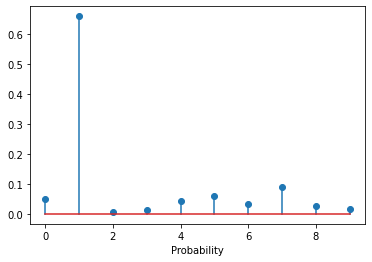

In [16]:
plt.stem(model.predict(ds_test.take(1))[9, :])
plt.xlabel("Digit")
plt.xlabel("Probability")


#|**Exercise - Transfer Learning**



In [17]:
data, info = tfds.load('rock_paper_scissors', with_info=True)
train_data = data["train"].map(lambda x: (tf.cast(x["image"], tf.float32) / 255., tf.one_hot(x["label"], depth=3) )).batch(32)

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete054TI7/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete054TI7/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [18]:
info.features['image'].shape

(300, 300, 3)

,image,label
0,,2 (scissors)
1,,2 (scissors)
2,,0 (rock)
3,,1 (paper)
4,,0 (rock)
5,,1 (paper)
6,,2 (scissors)
7,,1 (paper)
8,,2 (scissors)
9,,2 (scissors)

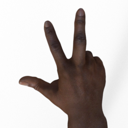
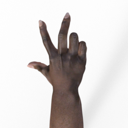
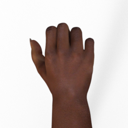
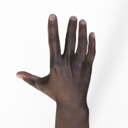
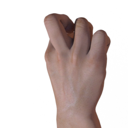
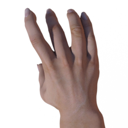
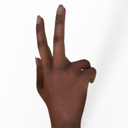
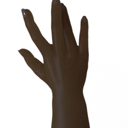
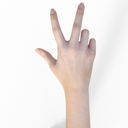
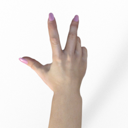

In [19]:
tfds.as_dataframe(data["train"].take(10), info)

# Exercise

1. Build a deep CNN model and train it for this binary classification task. Fit the model using the small dataset of 500 samples, *train_data*.

What accuracy can your model acheive on the training data?

In [20]:
# Your code here
data['train']
preprocess=lambda d: (tf.cast(d['image'],tf.float32)/255.0, d['label'])
ds_train=data['train'].map(preprocess).cache().batch(32).repeat().prefetch(10)
n_test=info.splits['test'].num_examples
ds_test=data['train'].map(preprocess).cache().take(n_test//4).batch(n_test//4).repeat().prefetch(2)

In [21]:
img_shape=info.features['image'].shape
img_shape

(300, 300, 3)

In [22]:
model=tfk.Sequential([tfkl.InputLayer(img_shape),
                      tfkl.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu),
                      tfkl.MaxPool2D(pool_size=(3,3)),
                      tfkl.Conv2D(filters=16, kernel_size=(3,3), activation=tf.nn.relu),
                      tfkl.MaxPool2D(pool_size=(3,3)), 
                      tfkl.Conv2D(filters=8, kernel_size=(3,3), activation=tf.nn.relu),
                      tfkl.MaxPool2D(pool_size=(3,3)),
                      tfkl.Flatten(),
                      tfkl.Dense(units=100, activation=tf.nn.relu),
                      tfkl.Dense(units=3, activation=tf.nn.softmax)
                      ])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 97, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 8)         1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)              

In [23]:
opt=tfk.optimizers.Adam()
loss=tfk.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
results=model.fit(ds_train, steps_per_epoch=20, epochs=10, validation_data=ds_test, validation_steps=1)

Epoch 1/10
20/20 [==============================] - 37s 2s/step - loss: 1.0330 - val_loss: 0.8267
Epoch 2/10
20/20 [==============================] - 36s 2s/step - loss: 0.6392 - val_loss: 0.4140
Epoch 3/10
20/20 [==============================] - 36s 2s/step - loss: 0.2670 - val_loss: 0.1762
Epoch 4/10
20/20 [==============================] - 34s 2s/step - loss: 0.1289 - val_loss: 0.0814
Epoch 5/10
20/20 [==============================] - 35s 2s/step - loss: 0.0598 - val_loss: 0.0709
Epoch 6/10
20/20 [==============================] - 35s 2s/step - loss: 0.0160 - val_loss: 0.0458
Epoch 7/10
20/20 [==============================] - 34s 2s/step - loss: 0.0226 - val_loss: 0.0410
Epoch 8/10
20/20 [==============================] - 34s 2s/step - loss: 0.0209 - val_loss: 0.0316
Epoch 9/10
20/20 [==============================] - 35s 2s/step - loss: 0.0232 - val_loss: 0.0220
Epoch 10/10
20/20 [==============================] - 34s 2s/step - loss: 0.0042 - val_loss: 0.0222


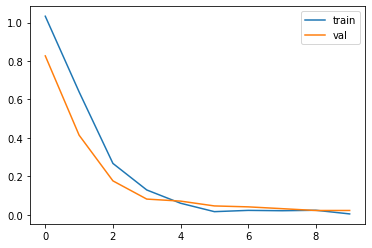

In [24]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(labels=["train", "val"])

 2. Now use transfer learning by incorporating the pretrained VGG16 model.

In [25]:
from tensorflow.keras.applications import VGG16

In [26]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(300,300,3))

58892288/58889256 [==============================] - 1s 0us/step


Build a Sequential model, using our VGG16 base. Make sure the freeze the weights of the convolutional backbone, but leave the remainder of the network weights as learnable. Fit this model and compare the overall accuracy as well as the loss curves (efficiency).


In [27]:
conv_base.trainable=False

In [28]:
model=tfk.Sequential([
                      tfkl.InputLayer(img_shape),
                      conv_base, 
                      tfkl.Conv2D(filters=8, kernel_size=(2,2),activation=tf.nn.relu),
                      tfkl.MaxPool2D(pool_size=(2,2)),
                      tfkl.Flatten(), 
                      tfkl.Dense(32,activation=tf.nn.relu),
                      tfkl.Dense(3, activation=tf.nn.softmax)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 8)           16392     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 14,735,307
Trainable params: 20,619
Non-trainable params: 14,714,688
_____________________________________

In [33]:
opt=tfk.optimizers.Adam()
loss=tfk.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
results=model.fit(ds_train, steps_per_epoch=10, epochs=10, validation_data=ds_test, validation_steps=1)

Epoch 1/10
10/10 [==============================] - 308s 31s/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 308s 31s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 7.5165e-04 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 307s 31s/step - loss: 5.3510e-04 - accuracy: 1.0000 - val_loss: 3.6603e-04 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 307s 31s/step - loss: 5.0694e-04 - accuracy: 1.0000 - val_loss: 1.9819e-04 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 306s 31s/step - loss: 2.3185e-04 - accuracy: 1.0000 - val_loss: 1.3406e-04 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 306s 31s/step - loss: 2.4228e-04 - accuracy: 1.0000 - val_loss: 1.1430e-04 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 306s 31s/step - loss: 1.8605e-04 - accuracy: 1.0000 - val_lo

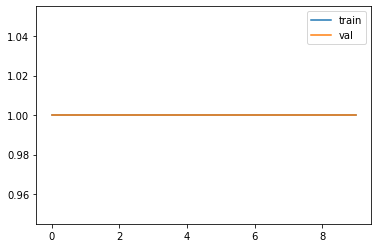

In [34]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(labels=["train", "val"])